# Explorador de resultados - evaluación_multimodelo.csv

Este notebook carga el CSV `evaluacion_multimodelo.csv` generado por tu pipeline y ofrece:
- Vista interactiva y filtrado con pandas.
- Resúmenes por modelo y por variable.
- Tablas pivot para comparar códigos entre modelos.
- Gráficos con `matplotlib` (sin estilos ni colores forzados).
- Métricas de consistencia (acuerdo entre modelos).

Guarda el CSV en el mismo directorio que este notebook o ajusta la ruta en la celda de carga.


In [1]:
# Cargar librerías y el CSV
import pandas as pd
import json
import matplotlib.pyplot as plt

# Ajusta la ruta si tu CSV está en otra ubicación
CSV_PATH = 'evaluacion_multimodelo.csv'

df = pd.read_csv(CSV_PATH, encoding='utf-8-sig')

# Mostrar un vistazo
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
df.head()


,modelo,texto,timestamp,error,model_errors,raw_response,cita_textual_titular__codigo,cita_textual_titular__evidencia,genero_nombre_propio_titular__codigo,genero_nombre_propio_titular__evidencia,genero_periodista__codigo,genero_periodista__evidencia,genero_personas_mencionadas__codigo,genero_personas_mencionadas__evidencia,nombre_propio_titular__codigo,nombre_propio_titular__evidencia,personas_mencionadas__codigo,personas_mencionadas__evidencia,tema__codigo,tema__evidencia
0,ollama/qwen3:8b,"María López presentó un estudio. ""Hemos encontrado resultados prometedores"" dijo la investigadora. El reportaje fue redactado por Laura García.",2025-11-12 09:59:56,NaN,[],"{\n ""cita_textual_titular"": {\n ""codigo"": ""0"",\n ""evidencia"": []\n },\n ""genero_nombre_propio_titular"": {\n ""codigo"": ""2"",\n ""evidencia"": [""María López""]\n },\n ""genero_periodista...",0.0,[],2.0,"[""María López""]",2.0,"[""Laura García""]",4.0,"[""María López"", ""Laura García""]",2.0,"[""María López""]",4.0,"[""María López"", ""Laura García""]",15.0,"[""presentó un estudio"", ""resultados prometedores""]"
1,ollama/qwen3:8b,El entrenador aseguró que el equipo trabajará duro. El columnista Juan Pérez destacó el esfuerzo de los jugadores.,2025-11-12 10:00:33,NaN,[],"{\n ""cita_textual_titular"": {""codigo"": ""0"", ""evidencia"": []},\n ""genero_nombre_propio_titular"": {""codigo"": ""4"", ""evidencia"": []},\n ""genero_periodista"": {""codigo"": ""1"", ""evidencia"": [""El column...",0.0,[],4.0,[],1.0,"[""El columnista Juan Pérez destacó el esfuerzo de los jugadores""]",4.0,"[""el entrenador"", ""Juan Pérez""]",4.0,[],4.0,"[""el entrenador"", ""Juan Pérez""]",8.0,"[""equipo"", ""jugadores"", ""esfuerzo""]"
2,ollama/qwen3:8b,"La presidenta anunció nuevas medidas económicas junto a su gabinete, conformado por hombres y mujeres.",2025-11-12 10:01:29,NaN,[],"{\n ""cita_textual_titular"": {\n ""codigo"": ""1"",\n ""evidencia"": [""La presidenta anunció nuevas medidas económicas junto a su gabinete, conformado por hombres y mujeres.""]\n },\n ""genero_nom...",1.0,"[""La presidenta anunció nuevas medidas económicas junto a su gabinete, conformado por hombres y mujeres.""]",4.0,[],7.0,[],4.0,"[""hombres y mujeres""]",4.0,[],4.0,"[""presidenta"", ""gabinete""]",8.0,"[""medidas económicas""]"
3,ollama/deepseek-r1:8b,"María López presentó un estudio. ""Hemos encontrado resultados prometedores"" dijo la investigadora. El reportaje fue redactado por Laura García.",2025-11-12 10:01:57,No JSON válido en ollama/deepseek-r1:8b,NaN,"{\n 'cita_textual_titular': {'codigo': '1', 'evidencia': [""'Hemos encontrado resultados prometedors' dijo la investigadora""]},\n 'genero_nombre_propio_titular': {'codigo': '2', 'evidencia': ['Ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ollama/deepseek-r1:8b,El entrenador aseguró que el equipo trabajará duro. El columnista Juan Pérez destacó el esfuerzo de los jugadores.,2025-11-12 10:02:13,NaN,['Código inválido 5 en personas_mencionadas'],"```json\n{\n ""cita_textual_titular"": {""codigo"": ""0"", ""evidencia"": []},\n ""genero_nombre_propio_titular"": {""codigo"": ""3"", ""evidencia"": [""Juan Pérez""]},\n ""genero_periodista"": {""codigo"": ""1"", ""ev...",0.0,[],3.0,"[""Juan Pérez""]",1.0,"[""El columnista Juan Pérez destacó el esfuerzo de los jugadores.""]",1.0,"[""El entrenador aseguró que el equipo trabajará duro."", ""los jugadores""]",3.0,"[""Juan Pérez""]",5.0,[],5.0,[]


In [2]:
# Limpiar y normalizar columnas útiles
# Deserializar las evidencias (columnas terminadas en '__evidencia') para facilitar inspección opcional
evidence_cols = [c for c in df.columns if c.endswith('__evidencia')]
for c in evidence_cols:
    def try_load(x):
        try:
            return json.loads(x) if pd.notna(x) else []
        except Exception:
            return x
    df[c] = df[c].apply(try_load)

# Convertir códigos a cadenas limpias (por si hay NaN/float)
code_cols = [c for c in df.columns if c.endswith('__codigo')]
for c in code_cols:
    df[c] = df[c].apply(lambda x: str(int(x)) if (pd.notna(x) and isinstance(x, float) and x.is_integer()) else (str(x) if pd.notna(x) else None))

print('Filas totales:', len(df))
df.info()


Filas totales: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   modelo                                   18 non-null     object
 1   texto                                    18 non-null     object
 2   timestamp                                18 non-null     object
 3   error                                    6 non-null      object
 4   model_errors                             12 non-null     object
 5   raw_response                             15 non-null     object
 6   cita_textual_titular__codigo             12 non-null     object
 7   cita_textual_titular__evidencia          18 non-null     object
 8   genero_nombre_propio_titular__codigo     12 non-null     object
 9   genero_nombre_propio_titular__evidencia  18 non-null     object
 10  genero_periodista__codigo                12 no

In [3]:
# Resumen: conteos por modelo y variable (código más frecuente)
variables = [v for v in df.columns if v.endswith('__codigo')]
# Agrupar por modelo y mostrar el código más frecuente por variable
resumen = df.groupby('modelo')[variables].agg(lambda col: col.mode().iloc[0] if len(col.dropna())>0 else None)
resumen


,cita_textual_titular__codigo,genero_nombre_propio_titular__codigo,genero_periodista__codigo,genero_personas_mencionadas__codigo,nombre_propio_titular__codigo,personas_mencionadas__codigo,tema__codigo
modelo,,,,,,,
ollama/deepseek-r1:8b,0,3,1,1,3,5,5
ollama/gemma3:12b,0,2,0,2,0,0,1
ollama/gemma3:4b,None,None,None,None,None,None,None
ollama/llama3.1:8b,1,3,2,4,1,None,16
ollama/mistral:7b,1,3,1,4,None,1,10
ollama/qwen3:8b,0,4,1,4,4,4,8


In [4]:
# Comparación por variable: tabla pivot (texto x modelo) para una variable seleccionada
# Cambia 'tema__codigo' por la variable que quieras comparar
variable = 'tema__codigo'

pivot = df.pivot_table(index='texto', columns='modelo', values=variable, aggfunc='first')
pivot


modelo,ollama/deepseek-r1:8b,ollama/gemma3:12b,ollama/llama3.1:8b,ollama/mistral:7b,ollama/qwen3:8b
texto,,,,,
El entrenador aseguró que el equipo trabajará duro. El columnista Juan Pérez destacó el esfuerzo de los jugadores.,5,1,16,3,8
"La presidenta anunció nuevas medidas económicas junto a su gabinete, conformado por hombres y mujeres.",NaN,6,NaN,4,8
"María López presentó un estudio. ""Hemos encontrado resultados prometedores"" dijo la investigadora. El reportaje fue redactado por Laura García.",NaN,16,NaN,10,15


In [5]:
# Métrica sencilla de consistencia: para cada texto y variable, proporción de modelos que están de acuerdo con la moda
from collections import Counter
models = df['modelo'].unique().tolist()

def agreement_for_variable(var):
    rows = []
    for texto, group in df.groupby('texto'):
        codes = group[var].dropna().tolist()
        if not codes:
            rows.append({'texto': texto, 'agreement': None})
            continue
        cnt = Counter(codes)
        mode, mode_count = cnt.most_common(1)[0]
        agreement = mode_count / len(codes)
        rows.append({'texto': texto, 'mode': mode, 'agreement': agreement})
    return pd.DataFrame(rows)

# Ejemplo para 'tema__codigo'
agreement_df = agreement_for_variable('tema__codigo')
agreement_df


,texto,mode,agreement
0,El entrenador aseguró que el equipo trabajará duro. El columnista Juan Pérez destacó el esfuerzo de los jugadores.,8,0.200000
1,"La presidenta anunció nuevas medidas económicas junto a su gabinete, conformado por hombres y mujeres.",8,0.333333
2,"María López presentó un estudio. ""Hemos encontrado resultados prometedores"" dijo la investigadora. El reportaje fue redactado por Laura García.",15,0.333333


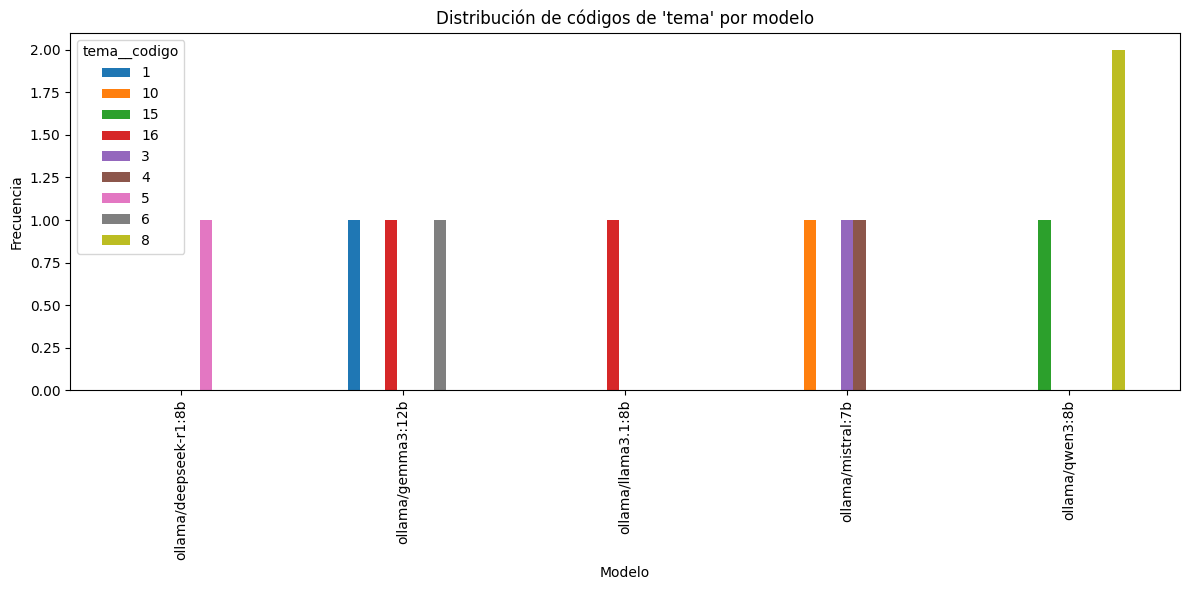

In [6]:
# Gráfico: distribución de 'tema' por modelo
# Se usa matplotlib directamente (sin seaborn, sin colores forzados)
var = 'tema__codigo'
count_table = df.groupby(['modelo', var]).size().unstack(fill_value=0)

ax = count_table.plot(kind='bar', figsize=(12,6))
ax.set_title("Distribución de códigos de 'tema' por modelo")
ax.set_ylabel('Frecuencia')
ax.set_xlabel('Modelo')
plt.tight_layout()
plt.show()


In [7]:
# Heatmap sencillo de coincidencia entre dos modelos para una variable
# Selecciona dos modelos para comparar
model_a = models[0] if 'models' in globals() else df['modelo'].unique()[0]
model_b = df['modelo'].unique()[-1]

var = 'tema__codigo'
sub = df[[ 'texto', 'modelo', var ]].pivot_table(index='texto', columns='modelo', values=var, aggfunc='first')

# Contar coincidencias entre model_a y model_b
compare = sub[[model_a, model_b]].dropna()
confusion = pd.crosstab(compare[model_a], compare[model_b])
print('Comparación entre', model_a, 'y', model_b)
display(confusion)


Comparación entre ollama/qwen3:8b y ollama/mistral:7b


ollama/mistral:7b,10,3,4
ollama/qwen3:8b,,,
15,1,0,0
8,0,1,1


In [ ]:
# Exportar resumen de consistencia a CSV
agreement_df.to_csv('consistencia_tema_por_texto.csv', index=False, encoding='utf-8-sig')
print('Resumen de consistencia guardado en: consistencia_tema_por_texto.csv')
